In [ ]:
#loading in the packages
import pyxdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [ ]:
#select data for timing validation + file paths
PARTICIPANTS = {
    'P295': {
        'xdf': '/work/BSc_Project/data_analysis/eeg_data/sub-P295/ses-S001/eeg/sub-P295_ses-S001_task-Default_run-001_eeg.xdf',
        'csv': '/work/BSc_Project/data_analysis/eeg_data/participant_295_2025-12-02_data.csv'
    },
    'P320': {
        'xdf': '/work/BSc_Project/data_analysis/eeg_data/sub-P320/ses-S001/eeg/sub-P320_ses-S001_task-Default_run-001_eeg.xdf',
        'csv': '/work/BSc_Project/data_analysis/eeg_data/participant_320_2025-12-01_data.csv'
    },
    'P144': {
        'xdf': '/work/BSc_Project/data_analysis/eeg_data/sub-P144/ses-S001/eeg/sub-P144_ses-S001_task-Default_run-001_eeg.xdf',
        'csv': '/work/BSc_Project/data_analysis/eeg_data/participant_144_2025-12-01_data.csv'
    },
    'P321': {
        'xdf': '/work/BSc_Project/data_analysis/eeg_data/sub-P321/ses-S001/eeg/sub-P321_ses-S001_task-Default_run-001_eeg.xdf',
        'csv': '/work/BSc_Project/data_analysis/eeg_data/participant_321_2025-11-28_data.csv'
    },
    'P657': {
        'xdf': '/work/BSc_Project/data_analysis/eeg_data/sub-P657/ses-S001/eeg/sub-P657_ses-S001_task-Default_run-001_eeg.xdf',
        'csv': '/work/BSc_Project/data_analysis/eeg_data/participant_657_2025-12-01_data.csv'
    },
    'P000': {
        'xdf': '/work/BSc_Project/sub-P000_ses-S001_task-Default_run-001_eeg.xdf',
        'csv': '/work/BSc_Project/participant_000_2026-01-28_data.csv'
    },
}

#data to analyse - separate dataset for timing validation and analysis of the main experiment
PARTICIPANTS_TO_ANALYZE = ['P000']  

In [ ]:
#mapping  LSL markers to CSV timestamp columns

MARKER_COLUMN_MAPPING = {
    'TRIAL_START': ['fix_start_time'],  #trial stast ad fixation markers are sent at the same time
    'FIX_CROSS': ['fix_start_time'],
    'BLANK_SCREEN_PRE_CUE': ['blank_start_time'],
    'CUE_SHOW': ['cue_start_time'],
    'MOVE_START': ['cue_end_time'],  #move phase starts when cue dissapears
    'MOVEMENT_CUE': ['movement_cue_time'],
    'CIRCLE_EXIT': ['circle_exit_time'],
    'RETRIEVAL_START': ['drag_start_time'],
    'RETRIEVAL_END': ['drag_end_time'],
    'TRIAL_END': ['trial_end_time']
}

In [ ]:
#helper functions to process marker names and extract condition codes
def get_marker_base_name(marker):
    """Remove condition code suffix from marker name."""
    return re.sub(r'_\d{3}$', '', marker)

def extract_condition_code(marker):
    """Extract 3-digit condition code from marker."""
    match = re.search(r'_(\d{3})$', marker)
    return match.group(1) if match else None

In [ ]:
#load lsl and csv data for timing validation

def load_lsl_markers(xdf_file):
    """Load LSL markers from XDF file."""
    print(f"📂 Loading XDF: {xdf_file}")
    data, _ = pyxdf.load_xdf(xdf_file)
    
    marker_stream = next((s for s in data if s['info']['type'][0] == 'Markers'), None)
    if not marker_stream:
        raise ValueError("No marker stream found in XDF file")
    
    markers = [m[0] for m in marker_stream['time_series']]
    timestamps = marker_stream['time_stamps']
    
    df = pd.DataFrame({
        'marker': markers,
        'timestamp': timestamps,
        'base_marker': [get_marker_base_name(m) for m in markers],
        'condition_code': [extract_condition_code(m) for m in markers]
    })
    
    print(f"   ✓ Found {len(df)} markers")
    
    #print distribution of marker types
    marker_counts = df['base_marker'].value_counts()
    print(f"   ✓ Marker types found: {len(marker_counts)}")
    for marker_type in sorted(marker_counts.index):
        print(f"      - {marker_type}: {marker_counts[marker_type]} occurrences")
    
    return df

def load_psychopy_data(csv_file):
    """Load PsychoPy experiment data."""
    print(f"📂 Loading CSV: {csv_file}")
    df = pd.read_csv(csv_file)
    print(f"   ✓ Found {len(df)} trials")
    
    # Check which timestamp columns are available
    available_cols = []
    for marker, possible_cols in MARKER_COLUMN_MAPPING.items():
        for col in possible_cols:
            if col in df.columns and col not in available_cols:
                available_cols.append(col)
    
    print(f"   ✓ Available timestamp columns: {', '.join(available_cols)}")
    
    return df

In [ ]:
#timestamp validation function: LSL - PsychoPy
def validate_timestamps(lsl_df, psychopy_df):
    """
    Validate timing by comparing timestamps for ALL markers.
    
    Steps:
    1. Normalize both clocks to start at 0.00
    2. Match trials sequentially (chronological order)
    3. Compare timestamps for ALL matching events
    4. Calculate differences and report statistics
    """
 
    #check which markers are matched between files
    lsl_markers = set(lsl_df['base_marker'].unique())
    available_markers = {}
    
    for marker, possible_cols in MARKER_COLUMN_MAPPING.items():
        if marker in lsl_markers:
            for col in possible_cols:
                if col in psychopy_df.columns:
                    available_markers[marker] = col
                    break
    
    if not available_markers:
        print("\n❌ ERROR: No matching markers found!")
        print(f"   LSL markers: {', '.join(sorted(lsl_markers))}")
        print(f"   CSV columns: {', '.join(psychopy_df.columns)}")
        return None
    
    print(f"\n✓ Validating {len(available_markers)} marker types:")
    for marker, col in sorted(available_markers.items()):
        print(f"   - {marker} → {col}")
    
    #extract trial boundaries and match sequentially
    trial_starts = lsl_df[lsl_df['base_marker'] == 'TRIAL_START']
    trial_ends = lsl_df[lsl_df['base_marker'] == 'TRIAL_END']
    n_trials = min(len(trial_starts), len(trial_ends), len(psychopy_df))

    #collect timestamp pairs
    timestamp_pairs = []
    
    for trial_idx in range(n_trials):
        csv_trial = psychopy_df.iloc[trial_idx]
        
        #trial markers from lsl
        start_idx = trial_starts.index[trial_idx]
        end_idx = trial_ends.index[trial_idx]
        trial_markers = lsl_df.loc[start_idx:end_idx]
        
        #trial metadata
        trial_info = {
            'trial_sequential': trial_idx + 1,
            'block_n': csv_trial.get('block_n', np.nan),
            'trial_n_in_block': csv_trial.get('trial_n_in_block', np.nan),
            'condition_code': trial_markers.iloc[0]['condition_code'] if len(trial_markers) > 0 else None
        }
        
        #timestamp pairs for all markers in trial
        for marker_name, csv_col in available_markers.items():
            marker_rows = trial_markers[trial_markers['base_marker'] == marker_name]
        
            if len(marker_rows) == 0 or pd.isna(csv_trial[csv_col]): #skip if marker is not found or is nan
                continue
            
            #handle multiple occurrences
            lsl_timestamp = marker_rows['timestamp'].values[0]
            psychopy_timestamp = csv_trial[csv_col]
            
            timestamp_pairs.append({
                **trial_info,
                'marker': marker_name,
                'lsl_timestamp': lsl_timestamp,
                'psychopy_timestamp': psychopy_timestamp
            })
    
    if not timestamp_pairs:
        print("\n❌ No matching timestamp pairs found!")
        return None
    
    df = pd.DataFrame(timestamp_pairs)
    print(f"   ✓ Collected {len(df)} timestamp pairs across {len(available_markers)} marker types")
    
    #count pairs per marker type
    pairs_per_marker = df['marker'].value_counts()
    for marker in sorted(pairs_per_marker.index):
        print(f"      - {marker}: {pairs_per_marker[marker]} pairs")
    
    #normalise timestamps
    lsl_first = df['lsl_timestamp'].min()
    psychopy_first = df['psychopy_timestamp'].min()
    
    df['lsl_normalized'] = (df['lsl_timestamp'] - lsl_first) * 1000  #convert to ms
    df['psychopy_normalized'] = (df['psychopy_timestamp'] - psychopy_first) * 1000
    
    #calculate timing differences
    df['timing_diff_ms'] = df['lsl_normalized'] - df['psychopy_normalized']
    
    #per-marker statistics
    for marker in sorted(available_markers.keys()): 
        marker_data = df[df['marker'] == marker]
        if len(marker_data) > 0:
            diffs = marker_data['timing_diff_ms']
            
            print(f"\n{marker}:")
            print(f"n = {len(diffs)} events")
            print(f"Mean difference: {diffs.mean():.3f} ms")
            print(f"SD (jitter): {diffs.std():.3f} ms")
            print(f"Range: [{diffs.min():.3f}, {diffs.max():.3f}] ms")
            print(f"95th percentile: {np.percentile(np.abs(diffs), 95):.3f} ms")
    
    #overall statistics
    all_diffs = df['timing_diff_ms']
    
    mean_diff = all_diffs.mean()
    sd_jitter = all_diffs.std()
    
    print(f"\n  n = {len(all_diffs)} events")
    print(f"Mean difference: {mean_diff:.3f} ms")
    print(f"SD (jitter): {sd_jitter:.3f} ms")
    print(f"Range: [{all_diffs.min():.3f}, {all_diffs.max():.3f}] ms")
    print(f"95th percentile: {np.percentile(np.abs(all_diffs), 95):.3f} ms")
    
    return df

In [ ]:
#visualisation

def plot_timing_validation(df, participant_id=''):
    """
    Create visualization of timing differences.
    CUE_SHOW and MOVE_START get distinct colors, all others are grey.
    """
    if df is None or len(df) == 0:
        return
    
    #single plot with all markers
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    # title = f'Timestamp Validation - Timing Differences Across Trials: {participant_id}' if participant_id else 'Timestamp Validation - Timing Differences Across Trials'
    # fig.suptitle(title, fontsize=14, fontweight='bold')
    
    markers = sorted(df['marker'].unique())
    
    #color mapping for the plot
    colors = []
    for marker in markers:
        if marker == 'CUE_SHOW':
            colors.append('#FF6B6B')  
        elif marker == 'MOVE_START':
            colors.append('#4ECDC4')  
        else:
            colors.append('#808080') 
    
    # track which legend labels are added
    legend_added = {'CUE_SHOW': False, 'MOVE_START': False, 'Remaining': False}
    
    for idx, marker in enumerate(markers):
        marker_data = df[df['marker'] == marker]
        
        #legend label based on marker type
        if marker == 'CUE_SHOW' and not legend_added['CUE_SHOW']:
            legend_label = 'CUE_SHOW'
            legend_added['CUE_SHOW'] = True
        elif marker == 'MOVE_START' and not legend_added['MOVE_START']:
            legend_label = 'MOVE_START'
            legend_added['MOVE_START'] = True
        elif marker not in ['CUE_SHOW', 'MOVE_START'] and not legend_added['Remaining']:
            legend_label = 'Remaining triggers'
            legend_added['Remaining'] = True
        else:
            legend_label = None 
        
        ax.scatter(marker_data['trial_sequential'], marker_data['timing_diff_ms'],
                   label=legend_label, alpha=0.7, s=30, color=colors[idx])
    
    ax.axhline(0, color='black', linestyle='-', linewidth=1.5)
    ax.axhline(5, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='±5ms')
    ax.axhline(-5, color='orange', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xlabel('Trial Number (Sequential)', fontsize=12)
    ax.set_ylabel('Timing Difference (ms)\nLSL - PsychoPy', fontsize=12)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    #save plot
    filename = f'timing_differences_plot_{participant_id}.png' if participant_id else 'timing_differences_plot.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"\n📊 Plot saved: {filename}")
    plt.show()

LSL TIMING VALIDATION - ALL MARKERS

Analyzing: P000

PROCESSING: P000
📂 Loading XDF: /work/BSc_Project/sub-P000_ses-S001_task-Default_run-001_eeg.xdf
   ✓ Found 1636 markers
   ✓ Marker types found: 28
      - BLANK_SCREEN_PRE_CUE: 162 occurrences
      - BLOCK_0_END: 1 occurrences
      - BLOCK_0_START_PRACTICE: 1 occurrences
      - BLOCK_1_END: 1 occurrences
      - BLOCK_1_START_SOCIAL: 1 occurrences
      - BLOCK_2_END: 1 occurrences
      - BLOCK_2_START_NON_SOCIAL: 1 occurrences
      - BLOCK_3_END: 1 occurrences
      - BLOCK_3_START_SOCIAL: 1 occurrences
      - BLOCK_4_END: 1 occurrences
      - BLOCK_4_START_NON_SOCIAL: 1 occurrences
      - BLOCK_5_END: 1 occurrences
      - BLOCK_5_START_SOCIAL: 1 occurrences
      - BLOCK_6_START_NON_SOCIAL: 1 occurrences
      - CIRCLE_EXIT: 81 occurrences
      - CUE_SHOW: 162 occurrences
      - FIX_CROSS: 163 occurrences
      - MOVEMENT_CUE: 81 occurrences
      - MOVE_END: 162 occurrences
      - MOVE_START: 162 occurrences
      -

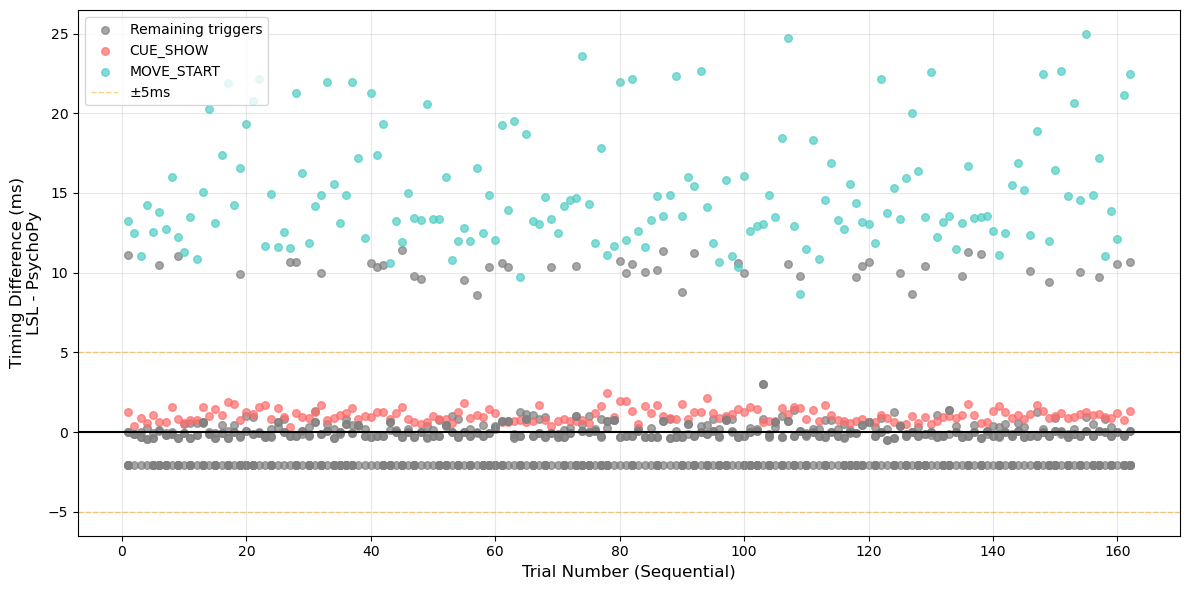


💾 Data saved: timestamp_validation_all_markers_P000.csv

💾 Combined data saved: timestamp_validation_all_markers_all_participants.csv

✅ VALIDATION COMPLETE


In [ ]:
#main processing function for a single participant
def process_participant(participant_id, xdf_file, csv_file):
    """Process a single participant."""
    print("\n" + "="*70)
    print(f"PROCESSING: {participant_id}")
    print("="*70)
    
    try:
        lsl_df = load_lsl_markers(xdf_file)
        psychopy_df = load_psychopy_data(csv_file)
        
        results = validate_timestamps(lsl_df, psychopy_df)
        
        if results is not None:
            plot_timing_validation(results, participant_id)
            
            output_file = f'timestamp_validation_all_markers_{participant_id}.csv'
            results.to_csv(output_file, index=False)
            print(f"\n💾 Data saved: {output_file}")
            
            return results
        
        return pd.DataFrame()
        
    except Exception as e:
        print(f"\n❌ Error processing {participant_id}: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()

def main():
    """Main function."""

    participants_to_process = (
        {k: v for k, v in PARTICIPANTS.items() if k in PARTICIPANTS_TO_ANALYZE}
        if PARTICIPANTS_TO_ANALYZE else PARTICIPANTS
    )
    
    if not participants_to_process:
        print("\n❌ No participants to analyze!")
        return
    
    print(f"\nAnalyzing: {', '.join(participants_to_process.keys())}")
    
    all_results = []
    
    for participant_id, files in participants_to_process.items():
        result = process_participant(participant_id, files['xdf'], files['csv'])
        if len(result) > 0:
            all_results.append(result)
    
    if not all_results:
        print("\n❌ No valid results!")
        return
    
    #combine and save  results
    combined = pd.concat(all_results, ignore_index=True)
    combined.to_csv('timestamp_validation_all_markers_all_participants.csv', index=False)
    
    
    #cross-participant summary
    if len(all_results) > 1:
        for marker in sorted(combined['marker'].unique()):
            marker_data = combined[combined['marker'] == marker]
            diffs = marker_data['timing_diff_ms']
            
            print(f"\n{marker}:")
            print(f"n = {len(diffs)} events ({len(all_results)} participants)")
            print(f"Mean difference: {diffs.mean():.3f} ms")
            print(f"SD (jitter): {diffs.std():.3f} ms")
        
        all_diffs = combined['timing_diff_ms']
        print(f"\nOVERALL:")
        print(f"n = {len(all_diffs)} events")
        print(f"Mean difference: {all_diffs.mean():.3f} ms")
        print(f"SD (jitter): {all_diffs.std():.3f} ms")

if __name__ == "__main__":
    main()
